In [138]:
from utils import *
from metrics import calculate_metrics
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from navec import Navec
from slovnet.model.emb import NavecEmbedding

import nltk
from nltk.tokenize import word_tokenize

import warnings

nltk.download("punkt")
plt.rcParams["figure.figsize"] = (15, 7)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abdulrasidmukuev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [88]:
# Скачиваем исходный файл с вакансиями
raw_df = pd.read_excel("data.xlsx", dtype="str")
raw_df.tail()

,id,description,skills_str
16995,98b5bd15-d1f6-11ec-8c63-57fc951f3846,NaN,"Исполнительность, Ответственность, Разработка ..."
16996,b715d743-dea9-11e6-853f-bf2cfe8c828d,NaN,"машиностроение, ремонт судовых механизмов, раз..."
16997,5d3d8182-80a2-11e9-8ba1-bf2cfe8c828d,NaN,"Фрезеровка, Работа в тисках, Обработка деталей..."
16998,a2d50a52-ab22-11ea-94f4-bf2cfe8c828d,NaN,"соблюдение норм, внутренний трудовой распорядо..."
16999,8d0b6c02-cb11-11ea-94f4-bf2cfe8c828d,NaN,"знание правил ручной резки, работа с одеждой и..."


In [89]:
# Избавляемся от вакансий без описания
df = raw_df.dropna(subset="description")
df.tail()

,id,description,skills_str
16916,31220962,Обязанности: Верстка и дизайн рекламной прод...,"Верстка, Дизайн, Разработка логотипов, Предпеч..."
16917,31285209,Обязанности: - проведение переговоров с предст...,"переговоры с организациями, разработка меропри..."
16918,40252884,"Обязанности: Управление группой продукции, ра...","управление продукцией, анализ потребностей кли..."
16919,23978165,"Обязанности: работа с сетевыми магазинами, по...","работа с сетевыми магазинами, выкладка продукц..."
16920,37498527,Обязанности: Поиск потенциальных клиентов по ...,"Поиск клиентов, Ведение клиента, Участие в тен..."


In [90]:
# Преобразуем датафрейм в BIO-нотацию
tagged_dataframes = [apply_to_row(row) for index, row in df.iterrows()]
result_df = pd.concat(tagged_dataframes).reset_index(drop=True)
result_df.tail()

,id,token,tag
1985222,37498527,10:00-18:00,O
1985223,37498527,лояльное,O
1985224,37498527,и,O
1985225,37498527,грамотное,O
1985226,37498527,руководство,O


In [91]:
# Сохраним result_df в отдельный файл
result_df.to_csv("data_bio.csv", encoding="utf-16", index=False)

In [92]:
# Скачиваем сохраненный result_df
result_df = pd.read_csv("data_bio.csv", encoding="utf-16")
result_df

,id,token,tag
0,16123526,обязанности,O
1,16123526,:,O
2,16123526,перевод,O
3,16123526,технической,O
4,16123526,документации,O
...,...,...,...
1985222,37498527,10:00-18:00,O
1985223,37498527,лояльное,O
1985224,37498527,и,O
1985225,37498527,грамотное,O


In [94]:
# Получаем уникальные идентификаторы вакансий
unique_ids = result_df['id'].unique()

# Разделяем идентификаторы вакансий на тренировочную, валидационную и тестовую группы
train_ids, temp_ids = train_test_split(unique_ids, test_size=2959, random_state=42) # 2959 это сумма 1500 и 1459
val_ids, test_ids = train_test_split(temp_ids, test_size=1459, random_state=42) # Разделяем оставшиеся на валидационные и тестовые

# Теперь разделяем исходный датафрейм на тренировочную, валидационную и тестовую выборки, используя полученные идентификаторы
train_df = result_df[result_df['id'].isin(train_ids)]
val_df = result_df[result_df['id'].isin(val_ids)]
test_df = result_df[result_df['id'].isin(test_ids)]

# Проверяем размерность данных
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 1447011
Validation size: 271767
Test size: 266449


In [95]:
# Функция для базовой оценки 
def calculate_baseline_accuracy(df):
    # Считаем, сколько раз тег совпал с "O"
    correct_predictions = df['tag'].value_counts().get('O', 0)
    # Общее количество предсказаний
    total_predictions = len(df)
    # Вычисляем точность
    accuracy = correct_predictions / total_predictions
    return accuracy

# Вычисляем точность для тренировочной, валидационной и тестовой выборок
print(f"Accuracy on training data: {calculate_baseline_accuracy(train_df):.4f}")
print(f"Accuracy on validation data: {calculate_baseline_accuracy(val_df):.4f}")
print(f"Accuracy on test data: {calculate_baseline_accuracy(test_df):.4f}")

Accuracy on training data: 0.9677
Accuracy on validation data: 0.9696
Accuracy on test data: 0.9642


In [96]:
# Загружаем эмбеддинги
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(path)  # ~1 sec, ~100MB RAM
emb = NavecEmbedding(navec)

print(torch.tensor(navec.vocab['собака']))
print(torch.tensor(navec.pq[navec.vocab['собака']])[:10])

tensor(406682)
tensor([-0.5378, -0.6289, -0.3964, -0.3829, -0.6061, -0.6350,  0.4124,  0.3353,
         0.4763, -0.6062])


In [97]:
# Преобразуем токены в эмбеддинги
grouped_train = train_df['id'].unique()
grouped_val = val_df['id'].unique()
grouped_test = test_df['id'].unique()

sentence_embeddings_train = []
sentence_embeddings_val = []
sentence_embeddings_test = []

for sentence in tqdm(grouped_train):
    sentence_words = list(train_df[train_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_train.append(embeddings_tensors)

for sentence in tqdm(grouped_val):
    sentence_words = list(val_df[val_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_val.append(embeddings_tensors)

for sentence in tqdm(grouped_test):
    sentence_words = list(test_df[test_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_test.append(embeddings_tensors)

100%|██████████| 1459/1459 [00:02<00:00, 588.77it/s]


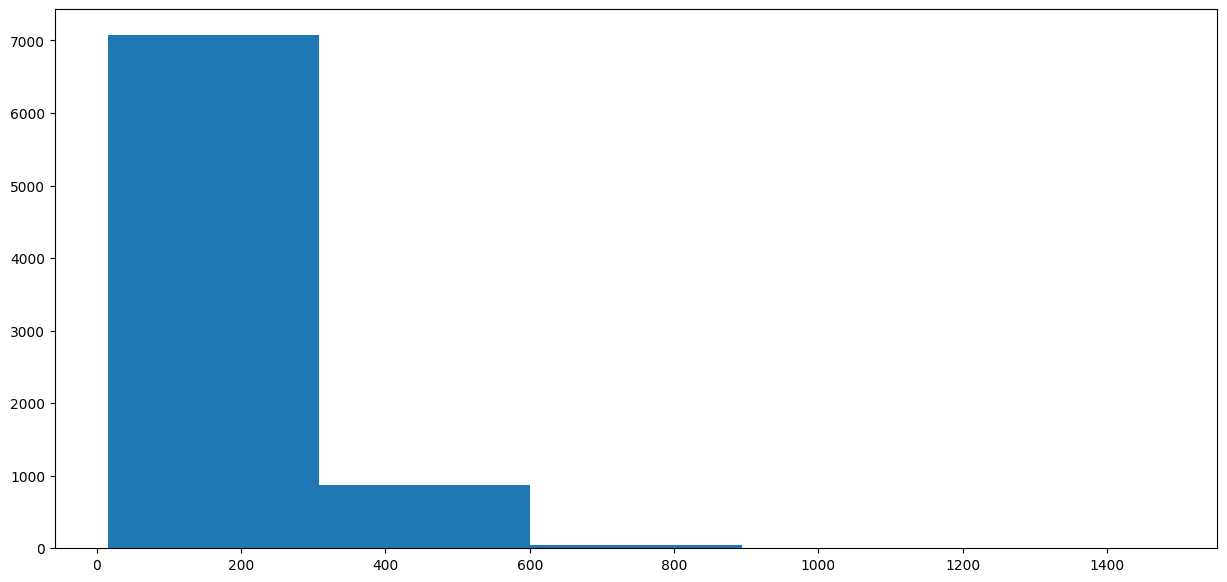

In [98]:
# Посмотрим на распределение длин вакансий
plt.hist(list(map(lambda x: x.shape[0], sentence_embeddings_train)), bins=5)
plt.show()

In [118]:
# Осуществляем паддинг для нормализации размерностей эмбеддингов
padded_embeddings_train = pad_sequences(sentence_embeddings_train, maxlen=300)
padded_embeddings_val = pad_sequences(sentence_embeddings_val, maxlen=300)
padded_embeddings_test = pad_sequences(sentence_embeddings_test, maxlen=300)

# Меняем формат векторов для корректной работы PyTorch
padded_embeddings_train = torch.tensor(padded_embeddings_train, dtype=torch.long)
padded_embeddings_val = torch.tensor(padded_embeddings_val, dtype=torch.long)
padded_embeddings_test = torch.tensor(padded_embeddings_test, dtype=torch.long)

print(padded_embeddings_train.shape)
print(padded_embeddings_val.shape)
print(padded_embeddings_test.shape)

torch.Size([8000, 300, 300])
torch.Size([1500, 300, 300])
torch.Size([1459, 300, 300])


In [119]:
# Создаем словарь тегов
tag_to_idx = {tag: i for i, tag in enumerate(result_df['tag'].unique())}

# Добавляем тег отсутствия
if "<pad>" not in tag_to_idx:
    tag_to_idx["<pad>"] = len(tag_to_idx)  

# Преобразуем теги в тензоры
grouped_train = train_df['id'].unique()
grouped_val = val_df['id'].unique()
grouped_test = test_df['id'].unique()

tags_sequences_train = []
tags_sequences_val = []
tags_sequences_test = []

for sentence in tqdm(grouped_train):
    sentence_tags = list(train_df[train_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_train.append(tags_tensor)

for sentence in tqdm(grouped_val):
    sentence_tags = list(val_df[val_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_val.append(tags_tensor)

for sentence in tqdm(grouped_test):
    sentence_tags = list(test_df[test_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_test.append(tags_tensor)

# Нормализуем теги
padded_tags_train = pad_sequences(tags_sequences_train, maxlen=300, value=tag_to_idx["<pad>"])
padded_tags_val = pad_sequences(tags_sequences_val, maxlen=300, value=tag_to_idx["<pad>"])
padded_tags_test = pad_sequences(tags_sequences_test, maxlen=300, value=tag_to_idx["<pad>"])

# Меняем формат векторов для корректной работы PyTorch
padded_tags_train = torch.tensor(padded_tags_train, dtype=torch.long)
padded_tags_val = torch.tensor(padded_tags_val, dtype=torch.long)
padded_tags_test = torch.tensor(padded_tags_test, dtype=torch.long)

print(padded_tags_train.shape)
print(padded_tags_val.shape)
print(padded_tags_test.shape)

100%|██████████| 1459/1459 [00:00<00:00, 6339.21it/s]

torch.Size([8000, 300])
torch.Size([1500, 300])
torch.Size([1459, 300])


In [120]:
# Строим архитектуру baseline-модели с одним LSTM-слоем
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(NERModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores.reshape(x.shape[0], x.shape[1], -1)

In [121]:
# Создаем структуру для подачи в модель
dataset_train = TensorDataset(padded_embeddings_train, padded_tags_train)
dataset_val = TensorDataset(padded_embeddings_val, padded_tags_val)
dataset_test = TensorDataset(padded_embeddings_test, padded_tags_test)

# Создание DataLoader'ов для тренировочного и валидационного наборов
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32)
test_loader = DataLoader(dataset_test, batch_size=32)

In [133]:
pd.Series(padded_tags_train.flatten()).value_counts()

0    1294618
3    1060030
2      22767
1      22585
Name: count, dtype: int64

Веса токенов:
Всего - 2 346 000
 - 0 - 55%
 - 1 - 1%
 - 2 - 1%
 - 3 - 43%

Новые веса:
 - 0 - 1.8
 - 1 - 100
 - 2 - 100
 - 3 - 2.32

Нормированные веса:
 - 0 - 0
 - 1 - 1
 - 2 - 1
 - 3 - 0

In [136]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.0, 1.0, 1.0, 0.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.7195, Val Loss: 0.6823, Precision: 0.0095, Recall: 0.5386, F1: 0.0187
Epoch 2, Train Loss: 0.6172, Val Loss: 0.5627, Precision: 0.0122, Recall: 0.6842, F1: 0.0239
Epoch 3, Train Loss: 0.5515, Val Loss: 0.5329, Precision: 0.0123, Recall: 0.6967, F1: 0.0242
Epoch 4, Train Loss: 0.5385, Val Loss: 0.5325, Precision: 0.0123, Recall: 0.6920, F1: 0.0241
Epoch 5, Train Loss: 0.5329, Val Loss: 0.5221, Precision: 0.0125, Recall: 0.7016, F1: 0.0244
Epoch 6, Train Loss: 0.5274, Val Loss: 0.5250, Precision: 0.0126, Recall: 0.7066, F1: 0.0246
Epoch 7, Train Loss: 0.5237, Val Loss: 0.5187, Precision: 0.0126, Recall: 0.7089, F1: 0.0247
Epoch 8, Train Loss: 0.5197, Val Loss: 0.5165, Precision: 0.0127, Recall: 0.7136, F1: 0.0249
Epoch 9, Train Loss: 0.5166, Val Loss: 0.5170, Precision: 0.0126, Recall: 0.7105, F1: 0.0247
Epoch 10, Train Loss: 0.5117, Val Loss: 0.5110, Precision: 0.0127, Recall: 0.7153, F1: 0.0249


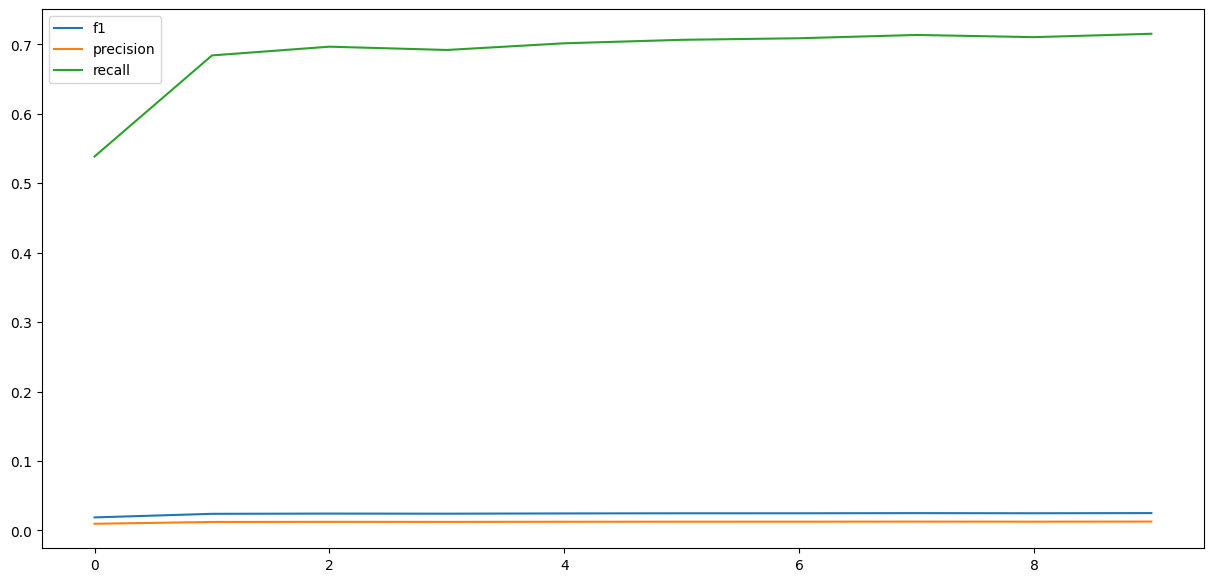

In [139]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [140]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.7530, Val Loss: 0.3448, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2, Train Loss: 0.4329, Val Loss: 0.1836, Precision: 0.0851, Recall: 0.0005, F1: 0.0011
Epoch 3, Train Loss: 0.5125, Val Loss: 0.2019, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 4, Train Loss: 0.1638, Val Loss: 0.1366, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 5, Train Loss: 0.4154, Val Loss: 0.7116, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 6, Train Loss: 0.5404, Val Loss: 0.2459, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 7, Train Loss: 0.1814, Val Loss: 0.1381, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 8, Train Loss: 0.3387, Val Loss: 0.1932, Precision: 0.0213, Recall: 0.0002, F1: 0.0003
Epoch 9, Train Loss: 0.1702, Val Loss: 0.1474, Precision: 0.0319, Recall: 0.0003, F1: 0.0006
Epoch 10, Train Loss: 0.1431, Val Loss: 0.1258, Precision: 0.1755, Recall: 0.0017, F1: 0.0033


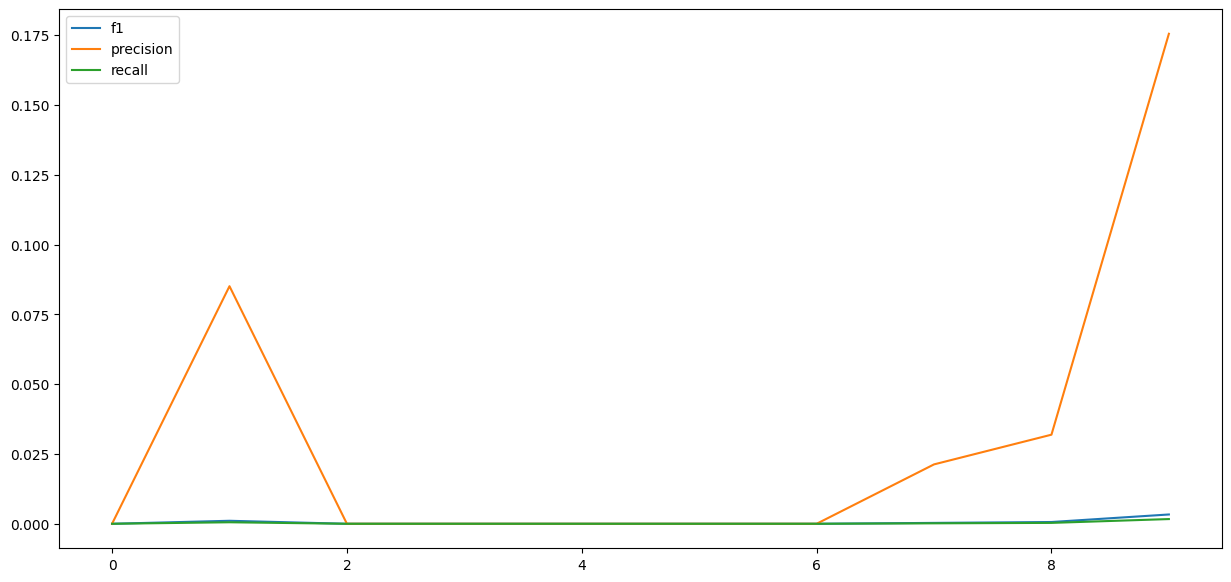

In [141]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [142]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.1]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.9311, Val Loss: 0.6519, Precision: 0.0426, Recall: 0.0004, F1: 0.0007
Epoch 2, Train Loss: 0.9886, Val Loss: 1.1101, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 3, Train Loss: 0.9850, Val Loss: 0.6537, Precision: 0.4090, Recall: 0.0078, F1: 0.0153
Epoch 4, Train Loss: 0.8750, Val Loss: 0.9249, Precision: 0.2728, Recall: 0.0132, F1: 0.0248
Epoch 5, Train Loss: 0.6053, Val Loss: 0.4786, Precision: 0.2124, Recall: 0.0646, F1: 0.0969
Epoch 6, Train Loss: 0.5619, Val Loss: 0.4715, Precision: 0.2507, Recall: 0.0650, F1: 0.1013
Epoch 7, Train Loss: 0.4750, Val Loss: 0.4468, Precision: 0.2088, Recall: 0.0940, F1: 0.1268
Epoch 8, Train Loss: 0.6347, Val Loss: 0.5806, Precision: 0.2298, Recall: 0.0396, F1: 0.0661
Epoch 9, Train Loss: 0.4967, Val Loss: 0.4404, Precision: 0.2334, Recall: 0.0809, F1: 0.1169
Epoch 10, Train Loss: 0.4484, Val Loss: 0.4233, Precision: 0.2404, Recall: 0.0976, F1: 0.1358


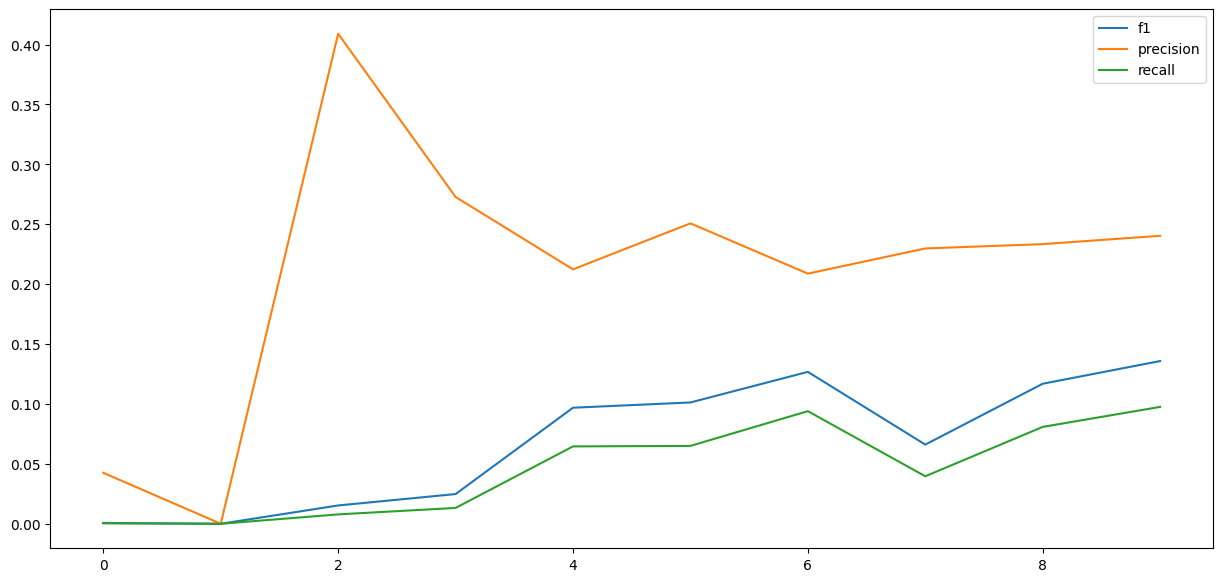

In [143]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [144]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.5, 1.0, 1.0, 0.5]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.8120, Val Loss: 0.2885, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2, Train Loss: 0.4548, Val Loss: 0.3877, Precision: 0.0638, Recall: 0.0005, F1: 0.0009
Epoch 3, Train Loss: 0.2457, Val Loss: 0.2041, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 4, Train Loss: 0.2024, Val Loss: 0.1829, Precision: 0.4510, Recall: 0.0089, F1: 0.0174
Epoch 5, Train Loss: 0.4497, Val Loss: 0.2037, Precision: 0.3177, Recall: 0.0042, F1: 0.0082
Epoch 6, Train Loss: 0.1940, Val Loss: 0.1877, Precision: 0.4010, Recall: 0.0186, F1: 0.0353
Epoch 7, Train Loss: 0.1840, Val Loss: 0.1792, Precision: 0.4063, Recall: 0.0161, F1: 0.0307
Epoch 8, Train Loss: 0.1795, Val Loss: 0.1661, Precision: 0.4270, Recall: 0.0210, F1: 0.0397
Epoch 9, Train Loss: 0.1746, Val Loss: 0.1636, Precision: 0.4132, Recall: 0.0254, F1: 0.0473
Epoch 10, Train Loss: 0.1726, Val Loss: 0.1609, Precision: 0.4134, Recall: 0.0264, F1: 0.0492


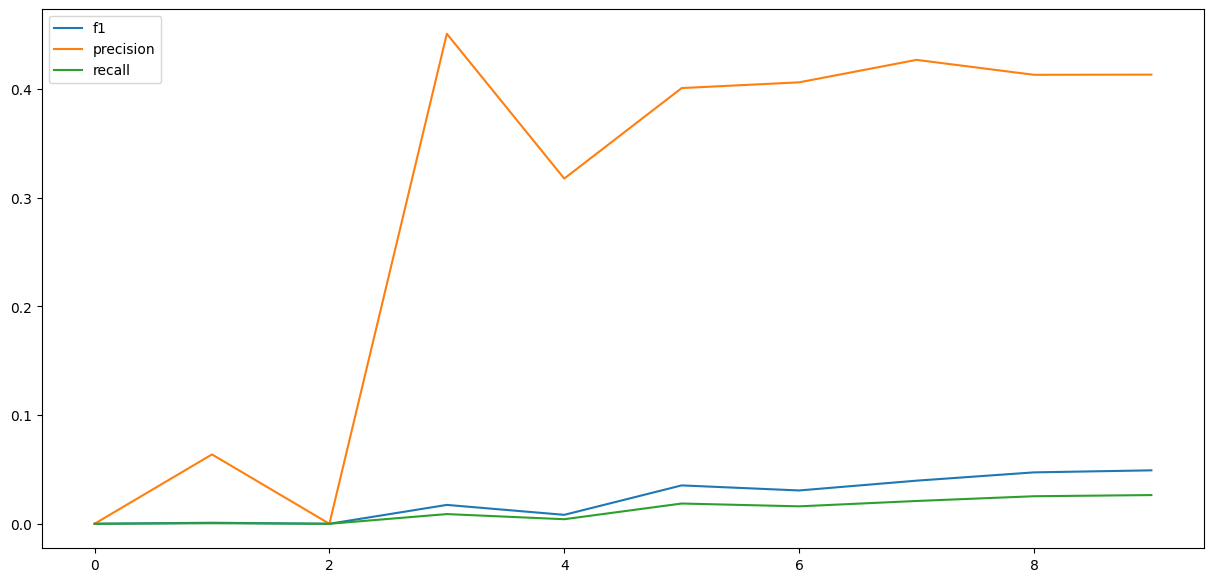

In [145]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [146]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.1]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.9221, Val Loss: 0.5473, Precision: 0.0213, Recall: 0.0002, F1: 0.0003
Epoch 2, Train Loss: 0.8825, Val Loss: 0.5223, Precision: 0.2523, Recall: 0.0266, F1: 0.0473
Epoch 3, Train Loss: 0.9593, Val Loss: 1.0563, Precision: 0.0408, Recall: 0.0004, F1: 0.0008
Epoch 4, Train Loss: 1.0420, Val Loss: 0.9682, Precision: 0.2584, Recall: 0.0091, F1: 0.0172
Epoch 5, Train Loss: 0.7486, Val Loss: 0.5656, Precision: 0.1601, Recall: 0.0240, F1: 0.0405
Epoch 6, Train Loss: 0.5066, Val Loss: 0.4630, Precision: 0.2692, Recall: 0.0544, F1: 0.0873
Epoch 7, Train Loss: 0.4683, Val Loss: 0.4357, Precision: 0.1721, Recall: 0.1043, F1: 0.1265
Epoch 8, Train Loss: 0.5650, Val Loss: 0.4720, Precision: 0.1550, Recall: 0.1093, F1: 0.1260
Epoch 9, Train Loss: 0.4669, Val Loss: 0.4362, Precision: 0.1678, Recall: 0.1461, F1: 0.1532
Epoch 10, Train Loss: 0.4355, Val Loss: 0.4113, Precision: 0.1895, Recall: 0.1510, F1: 0.1656
Epoch 11, Train Loss: 0.4245, Val Loss: 0.4051, Precision: 0.1757, Re

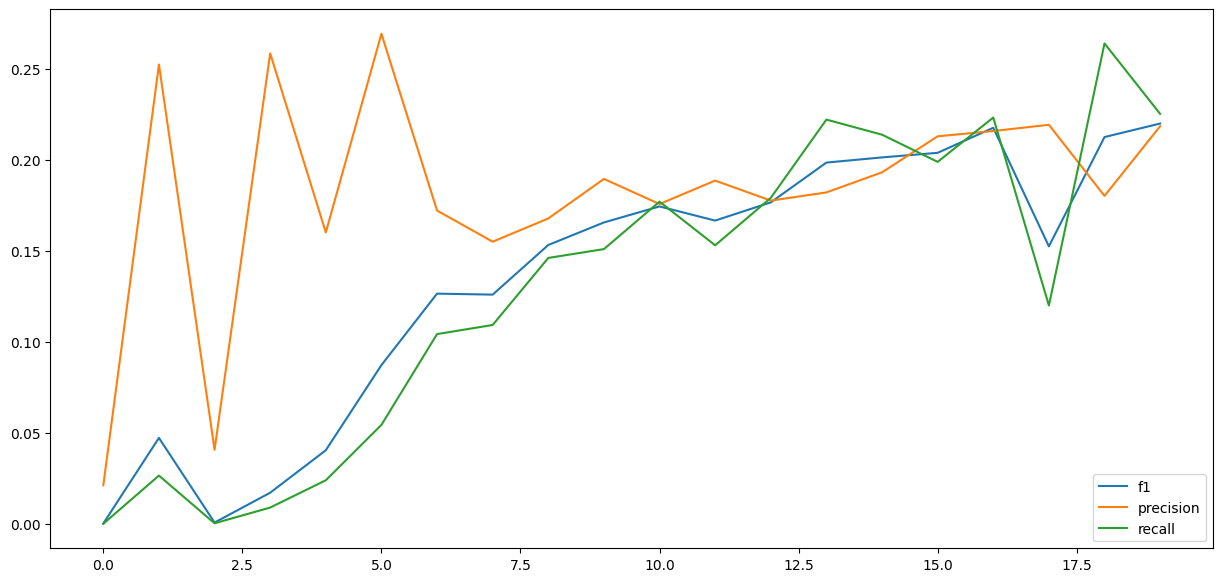

In [147]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [148]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.1]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.9818, Val Loss: 0.6373, Precision: 0.0213, Recall: 0.0004, F1: 0.0008
Epoch 2, Train Loss: 0.5472, Val Loss: 0.4748, Precision: 0.2001, Recall: 0.0286, F1: 0.0491
Epoch 3, Train Loss: 0.6269, Val Loss: 0.6198, Precision: 0.1008, Recall: 0.0624, F1: 0.0758
Epoch 4, Train Loss: 0.4976, Val Loss: 0.4350, Precision: 0.1965, Recall: 0.1157, F1: 0.1420
Epoch 5, Train Loss: 0.4495, Val Loss: 0.4201, Precision: 0.1872, Recall: 0.1469, F1: 0.1613
Epoch 6, Train Loss: 0.4372, Val Loss: 0.4110, Precision: 0.1967, Recall: 0.1683, F1: 0.1790
Epoch 7, Train Loss: 0.4261, Val Loss: 0.4046, Precision: 0.2150, Recall: 0.1960, F1: 0.2026
Epoch 8, Train Loss: 0.4213, Val Loss: 0.3975, Precision: 0.1926, Recall: 0.2172, F1: 0.2020
Epoch 9, Train Loss: 0.4475, Val Loss: 0.3993, Precision: 0.1761, Recall: 0.2405, F1: 0.2015
Epoch 10, Train Loss: 0.4126, Val Loss: 0.3944, Precision: 0.2250, Recall: 0.2027, F1: 0.2107
Epoch 11, Train Loss: 0.4067, Val Loss: 0.3890, Precision: 0.1648, Re

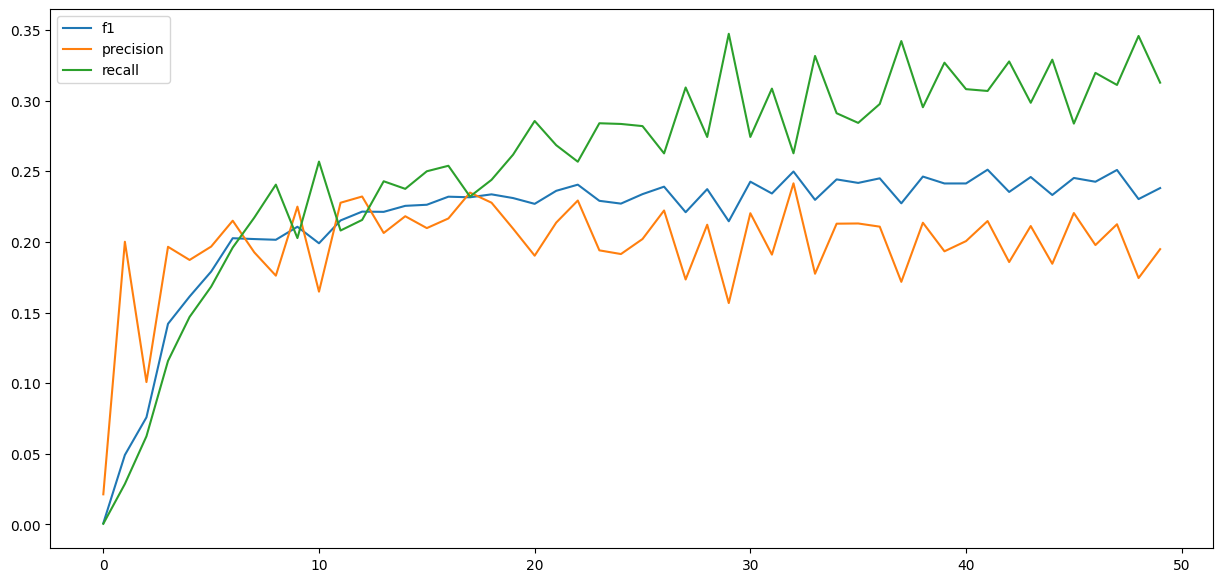

In [149]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [150]:
class NERModelConv1D(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(NERModelConv1D, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Переставляем размерности, потому что Conv1d ожидает (batch_size, channels, seq_length)
        x = x.permute(0, 2, 1)
        conv_out = self.conv1d(x)
        
        # Переставляем обратно, чтобы размерности соответствовали ожиданиям Linear и дальнейшей обработке
        conv_out = conv_out.permute(0, 2, 1)
        
        # Развертывание для линейного слоя
        tag_space = self.fc(conv_out.reshape(-1, conv_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        # Возвращаем к исходной размерности batch_size x seq_length x output_dim
        return tag_scores.reshape(x.shape[0], x.shape[2], -1)

In [151]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = NERModelConv1D(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.1]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.9811, Val Loss: 0.8464, Precision: 0.1973, Recall: 0.1117, F1: 0.1389
Epoch 2, Train Loss: 0.8527, Val Loss: 0.8318, Precision: 0.1682, Recall: 0.1241, F1: 0.1393
Epoch 3, Train Loss: 0.8467, Val Loss: 0.8294, Precision: 0.1545, Recall: 0.1295, F1: 0.1375
Epoch 4, Train Loss: 0.8451, Val Loss: 0.8292, Precision: 0.1534, Recall: 0.1284, F1: 0.1366
Epoch 5, Train Loss: 0.8444, Val Loss: 0.8288, Precision: 0.1754, Recall: 0.1240, F1: 0.1423
Epoch 6, Train Loss: 0.8442, Val Loss: 0.8294, Precision: 0.1593, Recall: 0.1280, F1: 0.1389
Epoch 7, Train Loss: 0.8443, Val Loss: 0.8278, Precision: 0.1783, Recall: 0.1197, F1: 0.1402
Epoch 8, Train Loss: 0.8437, Val Loss: 0.8292, Precision: 0.1759, Recall: 0.1230, F1: 0.1417
Epoch 9, Train Loss: 0.8438, Val Loss: 0.8283, Precision: 0.1666, Recall: 0.1258, F1: 0.1403
Epoch 10, Train Loss: 0.8441, Val Loss: 0.8280, Precision: 0.1698, Recall: 0.1248, F1: 0.1408


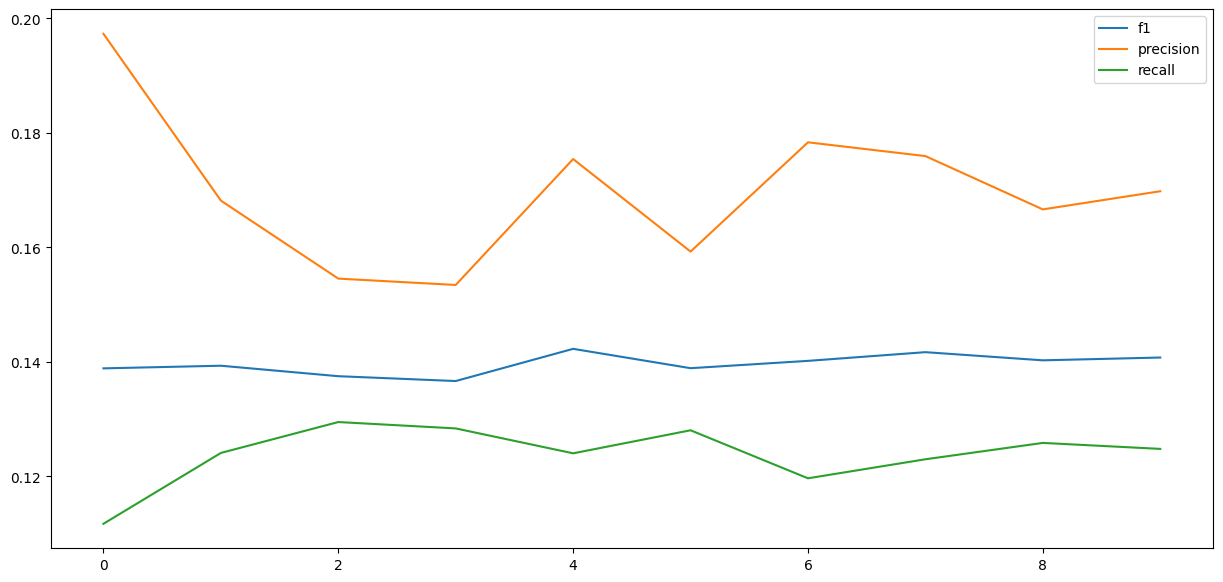

In [152]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [153]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(CNNBiLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        # После сверточного слоя выход будет иметь размерность hidden_dim, поэтому в LSTM она будет hidden_dim
        self.bilstm = nn.LSTM(hidden_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Переставляем размерности для Conv1d
        x = x.permute(0, 2, 1)
        conv_out = self.conv1d(x)
        
        # Переставляем обратно размерности для подачи в LSTM
        conv_out = conv_out.permute(0, 2, 1)
        
        # Пропускаем через BiLSTM
        lstm_out, _ = self.bilstm(conv_out)
        
        # Подаем на полносвязный слой
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        # Возвращаем к размерности batch_size x seq_length x output_dim
        return tag_scores.reshape(x.shape[0], x.shape[2], -1)

In [154]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = CNNBiLSTMModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.1]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.5820, Val Loss: 0.4244, Precision: 0.1324, Recall: 0.0795, F1: 0.0967
Epoch 2, Train Loss: 0.4230, Val Loss: 0.3920, Precision: 0.1947, Recall: 0.1390, F1: 0.1595
Epoch 3, Train Loss: 0.4001, Val Loss: 0.3758, Precision: 0.2014, Recall: 0.1910, F1: 0.1935
Epoch 4, Train Loss: 0.3882, Val Loss: 0.3662, Precision: 0.1892, Recall: 0.2162, F1: 0.2000
Epoch 5, Train Loss: 0.3799, Val Loss: 0.3674, Precision: 0.1358, Recall: 0.2950, F1: 0.1848
Epoch 6, Train Loss: 0.3707, Val Loss: 0.3590, Precision: 0.1897, Recall: 0.2417, F1: 0.2108
Epoch 7, Train Loss: 0.3661, Val Loss: 0.3598, Precision: 0.2306, Recall: 0.2093, F1: 0.2172
Epoch 8, Train Loss: 0.3617, Val Loss: 0.3529, Precision: 0.2022, Recall: 0.2460, F1: 0.2202
Epoch 9, Train Loss: 0.3569, Val Loss: 0.3503, Precision: 0.1744, Recall: 0.3071, F1: 0.2211
Epoch 10, Train Loss: 0.3523, Val Loss: 0.3485, Precision: 0.1716, Recall: 0.3128, F1: 0.2202


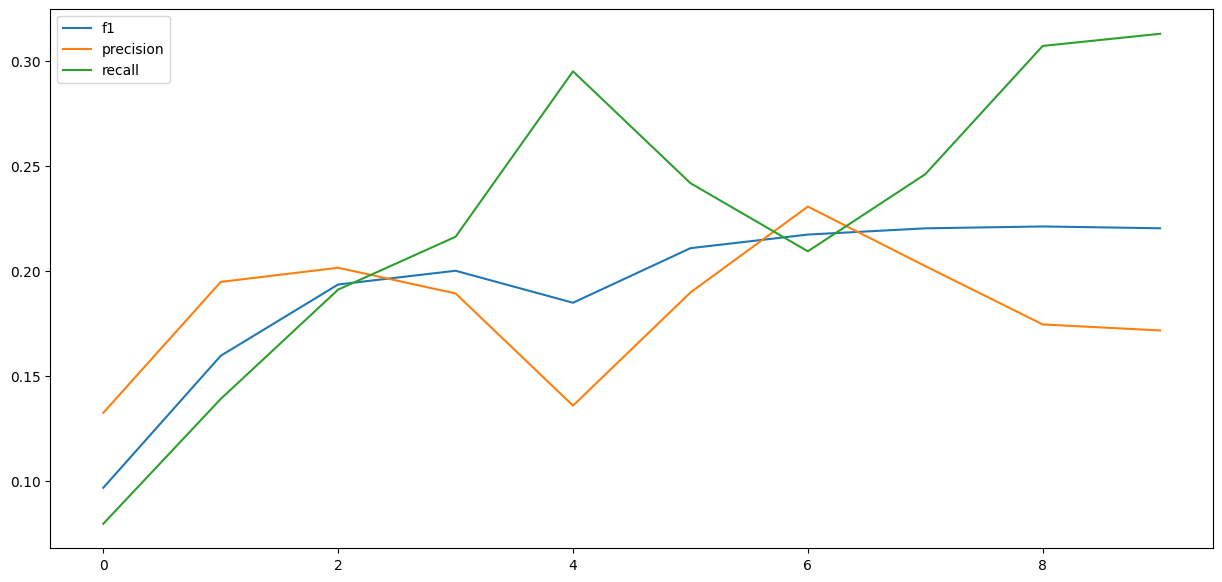

In [155]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [156]:
class DeepCNNBiLSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(DeepCNNBiLSTMModel, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        # Пулинг можно добавить для уменьшения размерности
        self.pool = nn.MaxPool1d(2, stride=2)
        # Двунаправленный LSTM
        self.bilstm = nn.LSTM(hidden_dim, hidden_dim // 2, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)
        # Полносвязный слой
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Переставляем размерности для Conv1d
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # Пулинг
        x = self.pool(x)
        # Переставляем обратно размерности для LSTM
        x = x.permute(0, 2, 1)
        # LSTM слой
        lstm_out, _ = self.bilstm(x)
        # Применяем полносвязный слой и softmax
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        # Возвращаем к размерности batch_size x seq_length x output_dim
        return tag_scores.reshape(x.shape[0], x.shape[2], -1)

In [157]:
# Параметры модели
embedding_dim = 300
hidden_dim = 256
output_dim = len(tag_to_idx)  # Количество уникальных тегов

# Инициализируем модель
model = CNNBiLSTMModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([0.1, 1.0, 1.0, 0.1]) 
loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Определяем оптимизатор с шагом обучения
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Массивы для визуализации обучения
avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

NUM_EPOCHS = 40
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch.float())
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch.float())
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.6102, Val Loss: 0.4219, Precision: 0.1666, Recall: 0.0494, F1: 0.0734
Epoch 2, Train Loss: 0.4272, Val Loss: 0.3985, Precision: 0.1888, Recall: 0.1133, F1: 0.1384
Epoch 3, Train Loss: 0.4183, Val Loss: 0.3848, Precision: 0.1755, Recall: 0.1983, F1: 0.1838
Epoch 4, Train Loss: 0.3950, Val Loss: 0.3805, Precision: 0.1592, Recall: 0.2390, F1: 0.1894
Epoch 5, Train Loss: 0.3845, Val Loss: 0.3810, Precision: 0.1388, Recall: 0.2919, F1: 0.1866
Epoch 6, Train Loss: 0.3781, Val Loss: 0.3624, Precision: 0.1598, Recall: 0.2807, F1: 0.2019
Epoch 7, Train Loss: 0.3707, Val Loss: 0.3582, Precision: 0.2203, Recall: 0.2328, F1: 0.2242
Epoch 8, Train Loss: 0.3649, Val Loss: 0.3578, Precision: 0.1526, Recall: 0.3203, F1: 0.2052
Epoch 9, Train Loss: 0.3598, Val Loss: 0.3490, Precision: 0.2002, Recall: 0.2751, F1: 0.2298
Epoch 10, Train Loss: 0.3547, Val Loss: 0.3454, Precision: 0.1903, Recall: 0.2980, F1: 0.2308
Epoch 11, Train Loss: 0.3512, Val Loss: 0.3462, Precision: 0.1735, Re

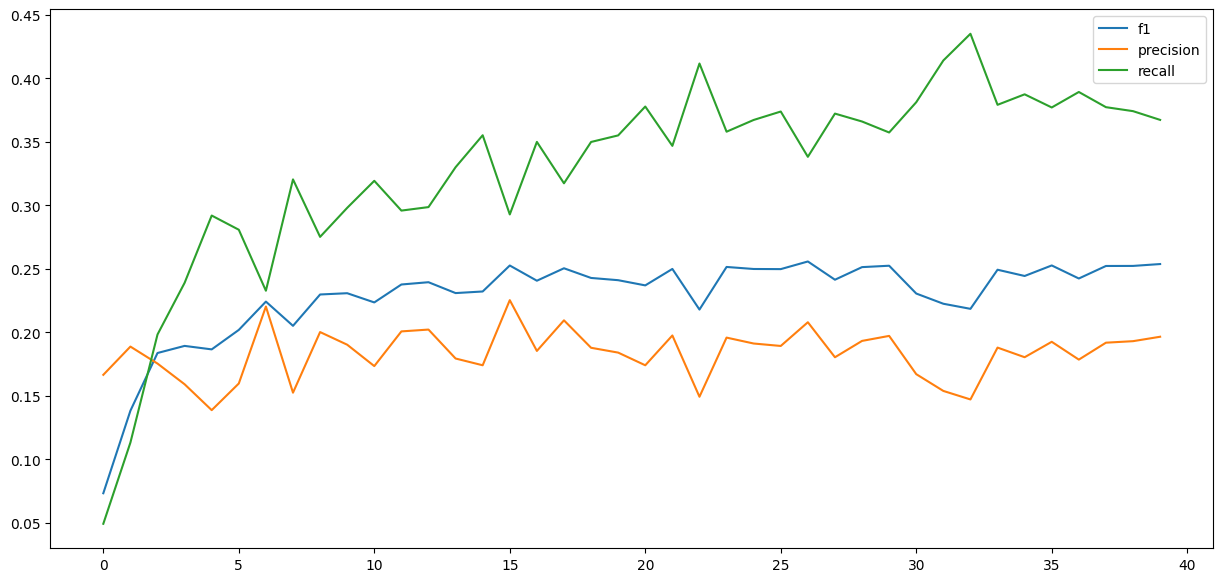

In [158]:
sns.lineplot(x = range(NUM_EPOCHS), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(NUM_EPOCHS), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()